In [9]:
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord
from dna_features_viewer.biotools import annotate_biopython_record
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO

In [10]:
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator implementing the following theme:

    - Color genes in blue, promoters in pink
    

    """

    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "blue"
        elif feature.type == "promoter":
            return "#fbb4ae"
        else:
            return "#b3cde3"

    def compute_feature_label(self, feature):
        if feature.type == "CDS":
            return "CDS here"
        elif feature.type == "promoter":
            # text returned here is the label displayed in the figure
            return None
        else:
            return BiopythonTranslator.compute_feature_label(self, feature)

    def compute_filtered_features(self, features):
        """Only display genes """
        return [
            feature for feature in features
            if (feature.type == "gene") #or feature.type=="promoter")
        ]




In [11]:
# Establish ordering of loci and drugs
name_list = [
        "acpM-kasA",
        "gid",
        "rpsA",
        "clpC",
        "embCAB",
        "aftB-ubiA",
        "rrs-rrl",
        "ethAR",
        "oxyR-ahpC",
        "tlyA",
        "KatG",
        "rpsL",
        "rpoBC",
        "FabG1-inhA",
        "eis",
        "gyrBA",
        "panD",
        "pncA"
    ]

drug_list = ['ETHIONAMIDE',
 'STREPTOMYCIN',
 'CAPREOMYCIN',
 'RIFAMPICIN',
 'PYRAZINAMIDE',
 'AMIKACIN',
 'KANAMYCIN',
 'ETHAMBUTOL',
 'OFLOXACIN',
 #'CIPROFLOXACIN',
 'MOXIFLOXACIN',
 'LEVOFLOXACIN',
 'ISONIAZID']


drug_to_loci = {
    'ETHIONAMIDE':[ "FabG1-inhA","ethAR"],
    'STREPTOMYCIN':["gid", "rrs-rrl", "rpsL"],
    'CAPREOMYCIN':["tlyA", "rrs-rrl"],
    'RIFAMPICIN':["rpoBC"],
    'PYRAZINAMIDE':["pncA", "panD", "clpC", "rpsA"],
    'AMIKACIN':["eis", "rrs-rrl"],
    'KANAMYCIN':["eis", "rrs-rrl"],
    'ETHAMBUTOL':["embCAB", "aftB-ubiA"],
    'OFLOXACIN':["gyrBA"],
    #'CIPROFLOXACIN':["gyrBA"],
    'MOXIFLOXACIN':["gyrBA"],
    'LEVOFLOXACIN':["gyrBA"],
    'ISONIAZID':["acpM-kasA", "oxyR-ahpC", "KatG", "FabG1-inhA"]
}

In [12]:
! cp ../../FocusCNN/analyze_saliency/X_matrix_H37RV_coords.npy ../output_data/

In [13]:
data_path = "../output_data/"

# Read in the coordinates of the model in H37Rv numbering
coords = np.load(f"{data_path}/X_matrix_H37RV_coords.npy")

# Models were padded with 0, so fill in with nans
coords[coords==0] = np.nan

# Confirm correct locus lengths
lens = coords.shape[0] - np.isnan(coords).sum(axis=0)
name_to_len = {}
for name, l in zip(name_list, lens):
    print(name, "length of locus", l)
    name_to_len[name] = l
 
# coords were 0-indexed so must add 1
coords = coords + 1



acpM-kasA length of locus 1670
gid length of locus 806
rpsA length of locus 1609
clpC length of locus 4206
embCAB length of locus 10147
aftB-ubiA length of locus 2880
rrs-rrl length of locus 5437
ethAR length of locus 2195
oxyR-ahpC length of locus 1303
tlyA length of locus 991
KatG length of locus 3471
rpsL length of locus 623
rpoBC length of locus 7711
FabG1-inhA length of locus 2554
eis length of locus 2531
gyrBA length of locus 4821
panD length of locus 2169
pncA length of locus 1716


In [18]:
!mkdir ../output_data/sd_cnn_saliency
!cp ../../FocusCNN/deeplift_saliency/singletask_v2/data/*npy ../output_data/sd_cnn_saliency

mkdir: figures: File exists


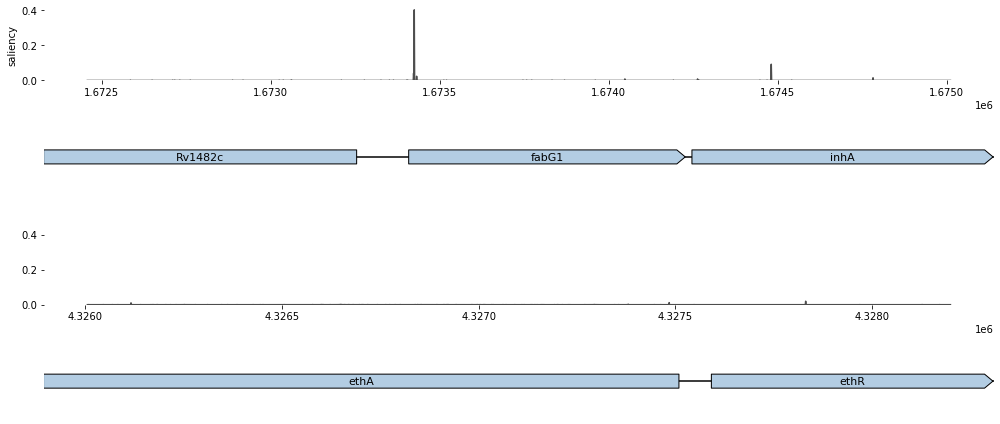

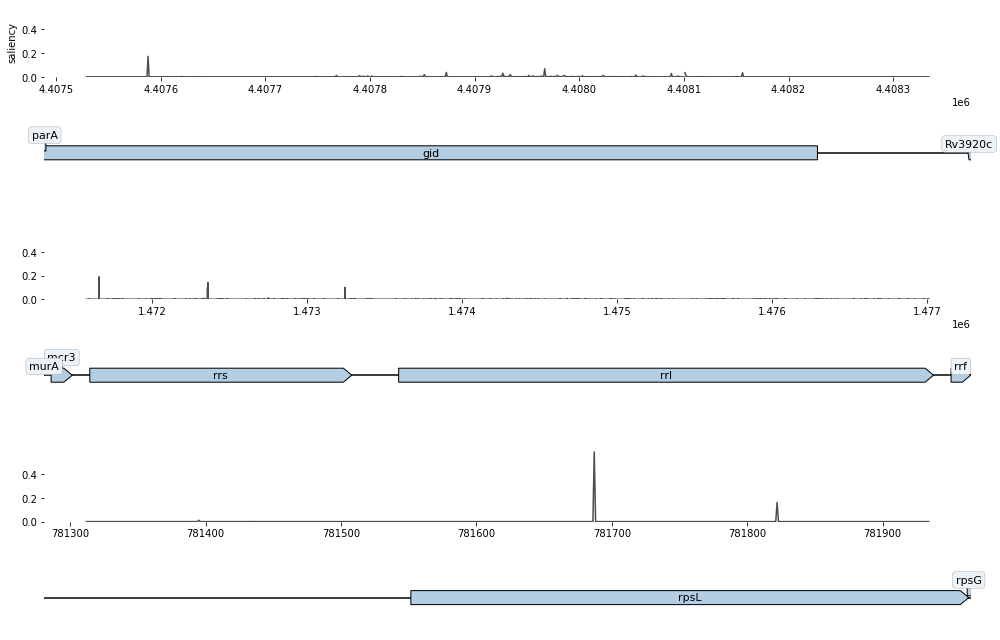

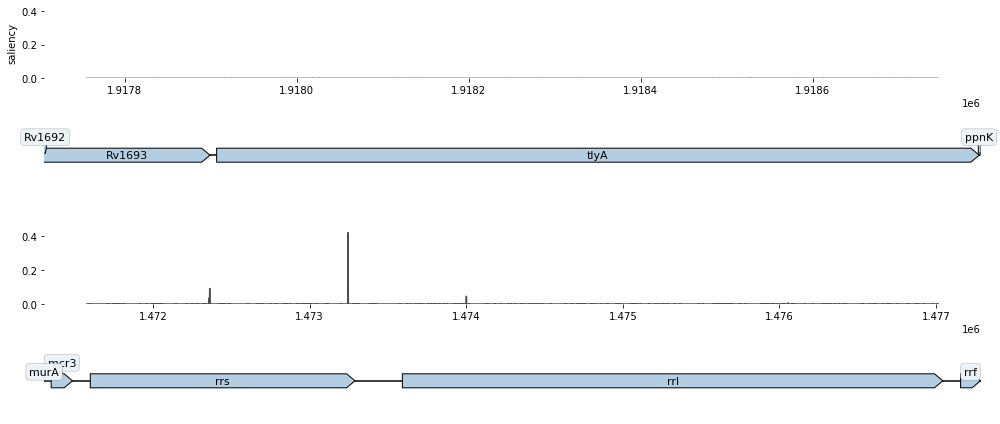

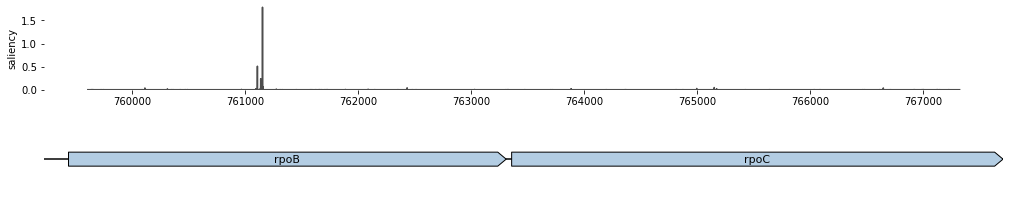

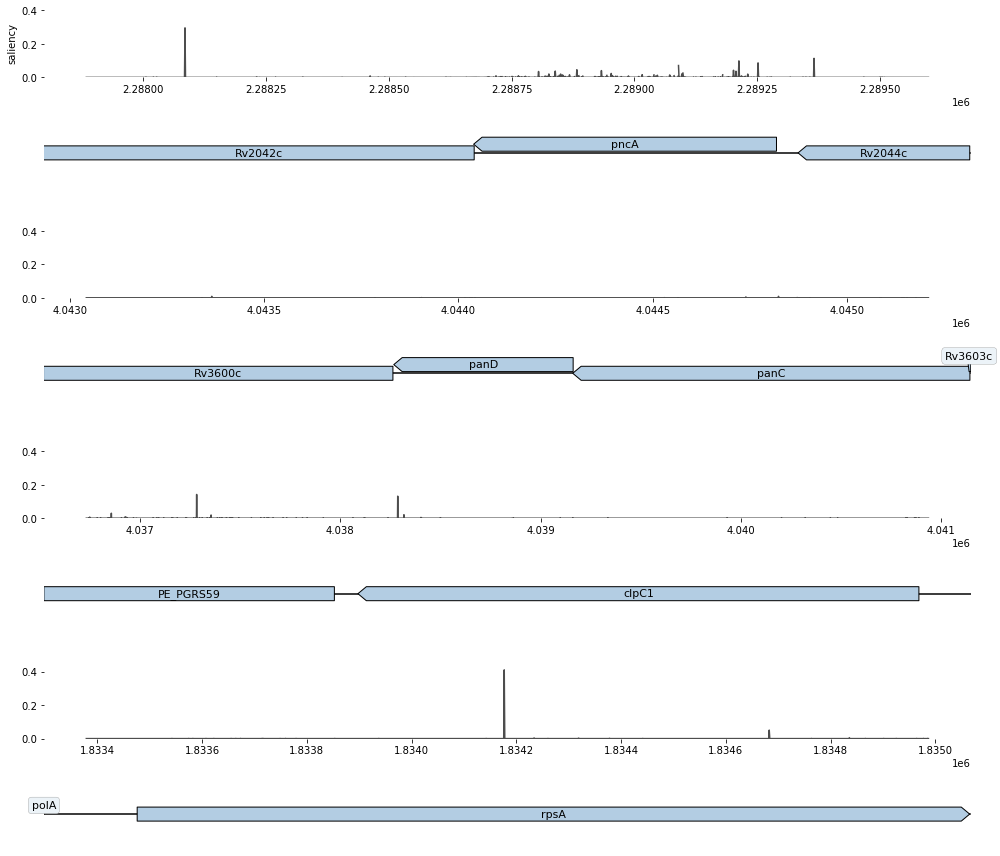

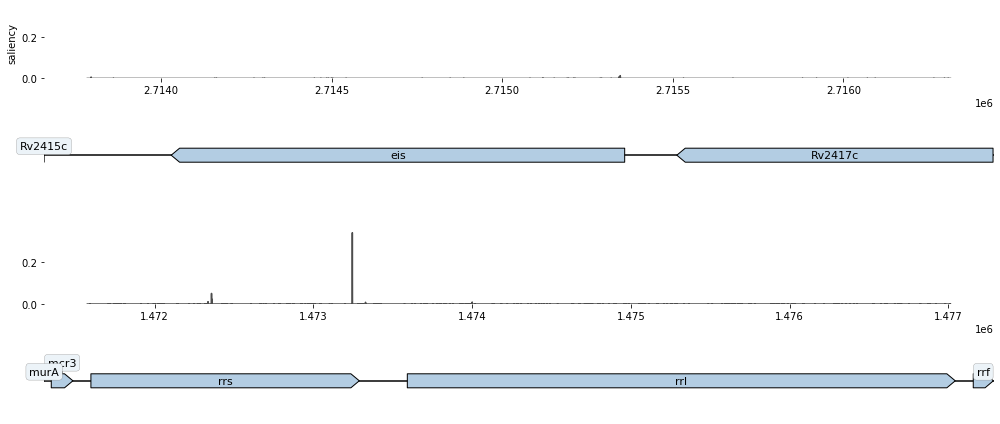

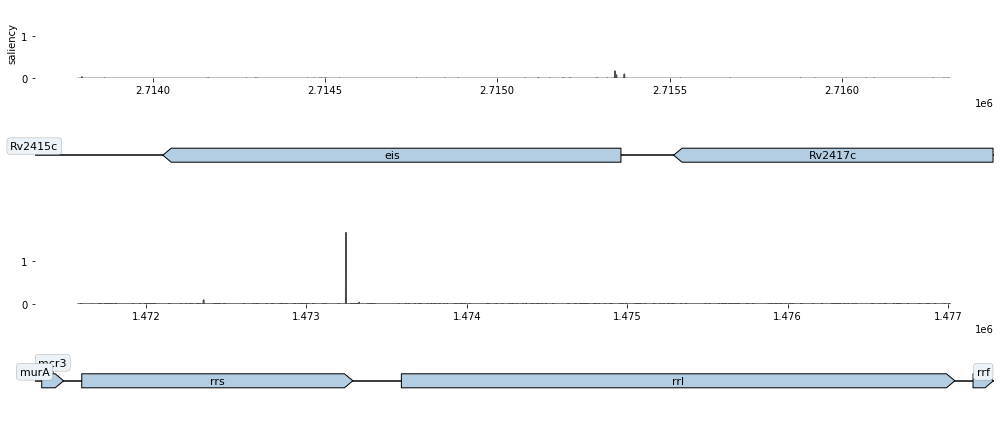

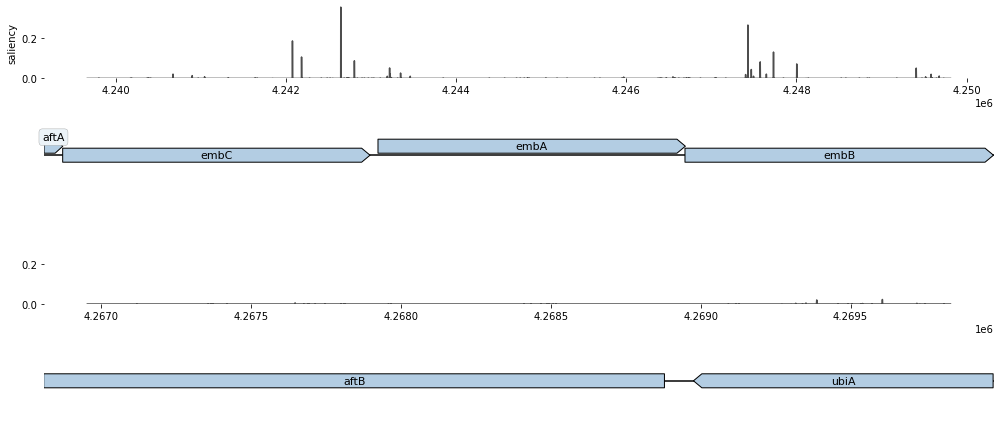

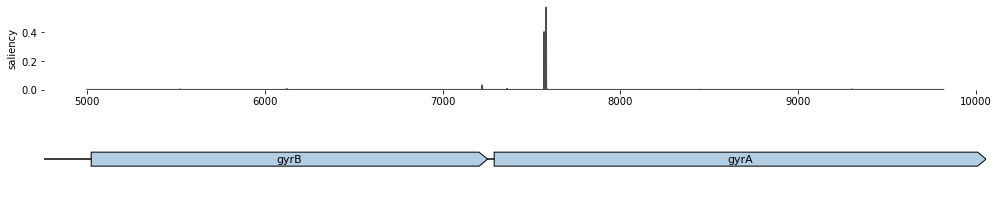

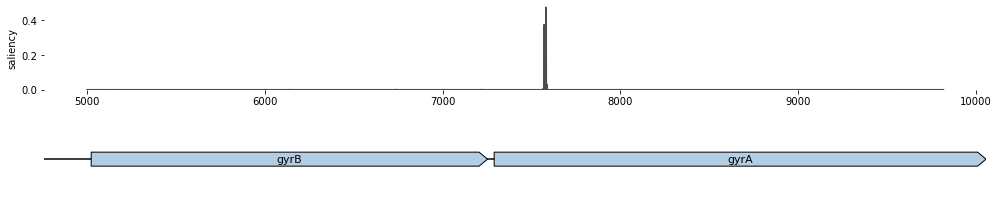

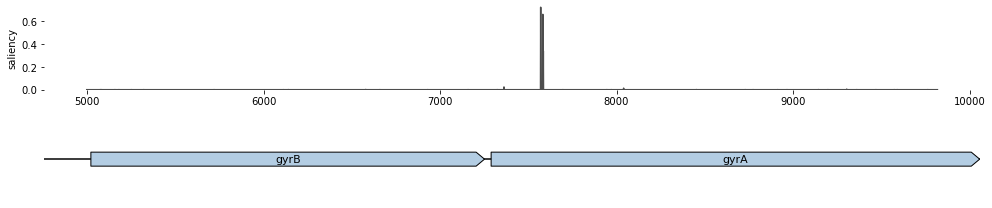

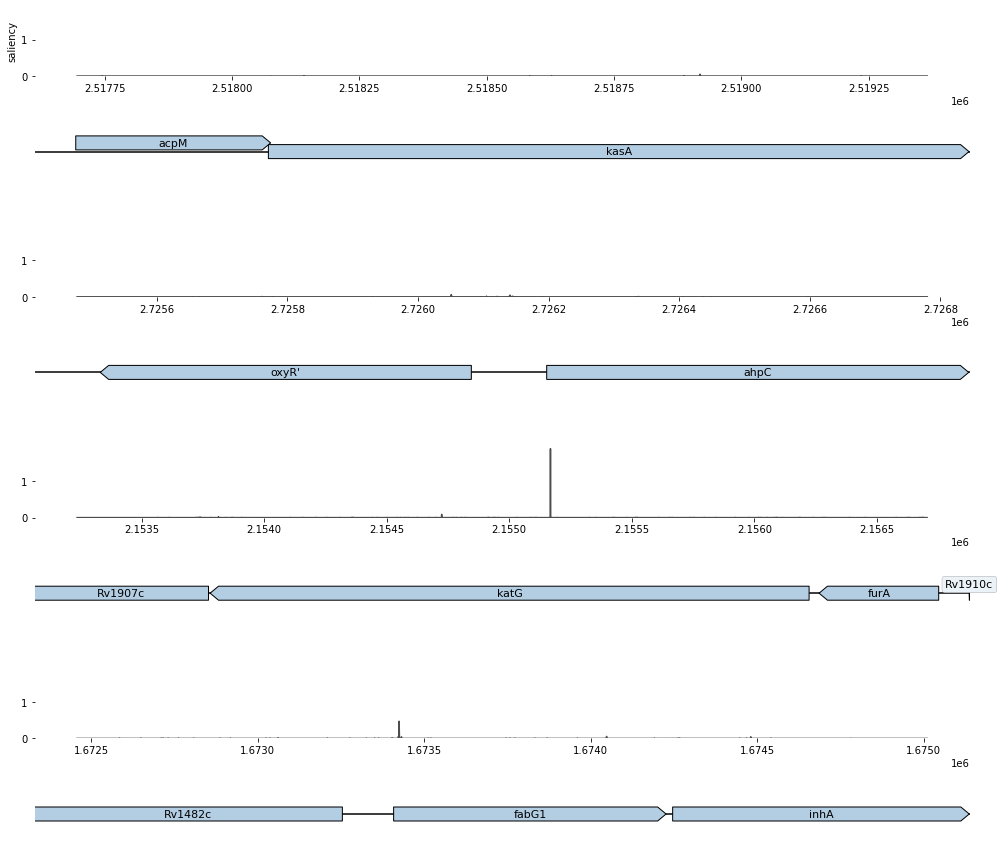

In [19]:
## Plotting activation for each gene locus - mean saliency across all resistant strains

!mkdir figures

record = SeqIO.read("../../../databases/GCF_000195955.2_ASM19595v2_genomic.gbff", "genbank")

graphic_record = MyCustomTranslator().translate_record(record)

for drug in drug_list:
    combined = np.load(f"{data_path}/sd_cnn_saliency/{drug}_mean.npy")
    combined = np.abs(combined)
    allbound=np.max(combined)
    
    ## Get the relevant coordinate subset
    locus_indices = [name_list.index(x) for x in drug_to_loci[drug]]
    coords_subset = coords[0:combined.shape[0]][:,locus_indices]
    
    fig, ax = plt.subplots(coords_subset.shape[1]*2, 1, figsize=(14,3*combined.shape[1]))
    axes=ax.flatten()

    for i,name in enumerate(drug_to_loci[drug]):

        ax_coords = axes[(i)*2+1]
        ax_saliency = axes[(i)*2]
        length =int(coords_subset[0,i])+ name_to_len[name]

        cropped_record = graphic_record.crop((int(coords_subset[0,i]), int(coords_subset[0,i])+name_to_len[name]))

        cropped_record.plot(
            ax=ax_coords, with_ruler=False,
        )

        ax_coords.set_xlim([int(coords_subset[0,i]), int(coords_subset[0,i])+ name_to_len[name]])
        ax_coords.set_ylim([-4,4])

        ax_saliency.plot(coords_subset[:,i], combined[:,i], color="#4d4d4d") 
        ax_saliency.set_ylim([0, allbound+0.01*allbound])

        sns.despine(ax=ax_saliency, top=True, right=True, left=True, bottom=True)


    ax[0].set_ylabel("saliency")

    #plt.suptitle(f"{drug.upper()} Saliency Map")
    plt.tight_layout()
    plt.savefig(f"figures/{drug}_mean.pdf") 


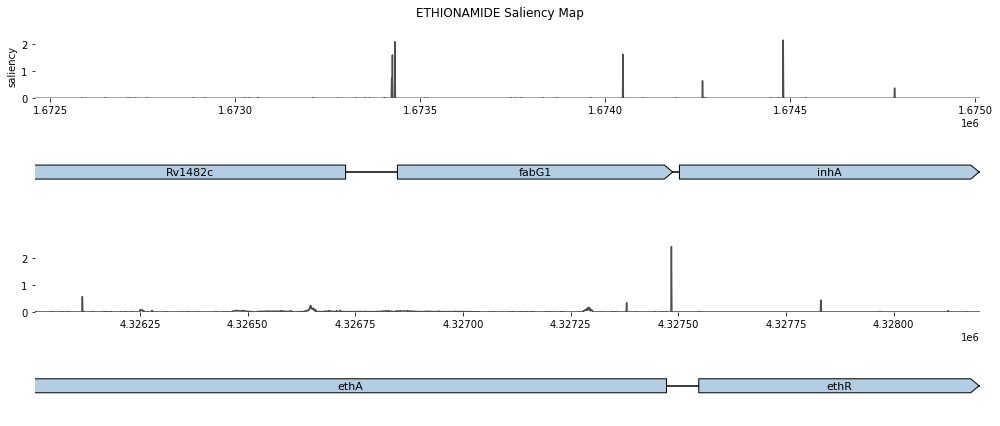

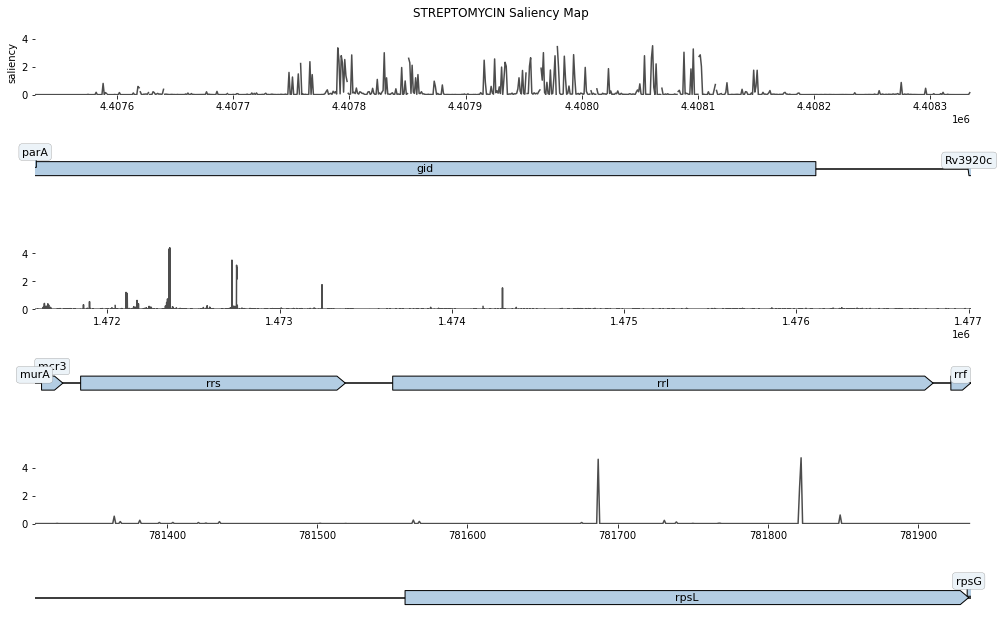

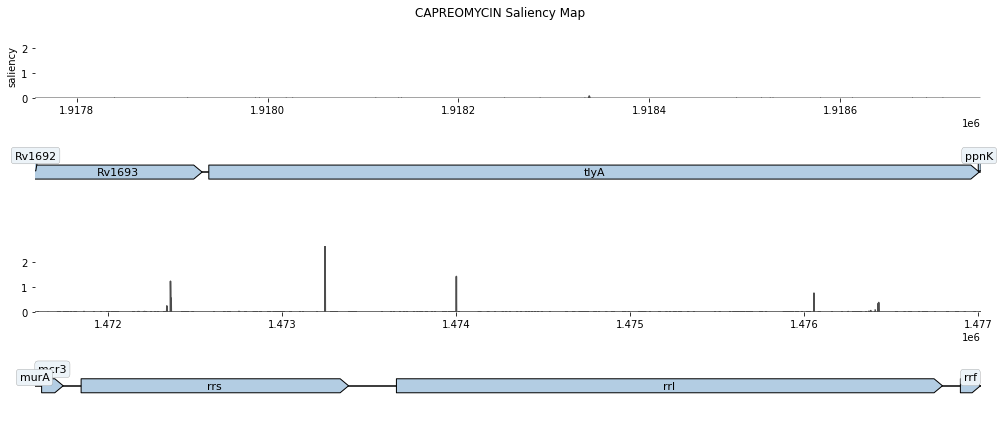

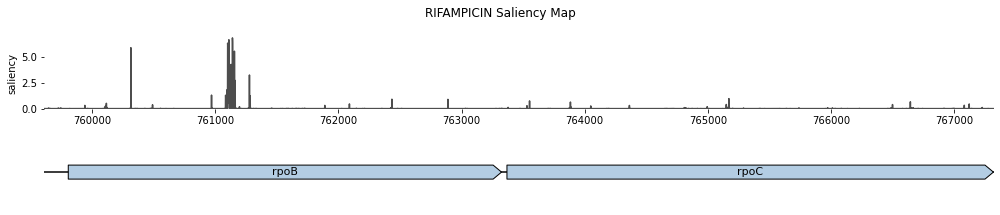

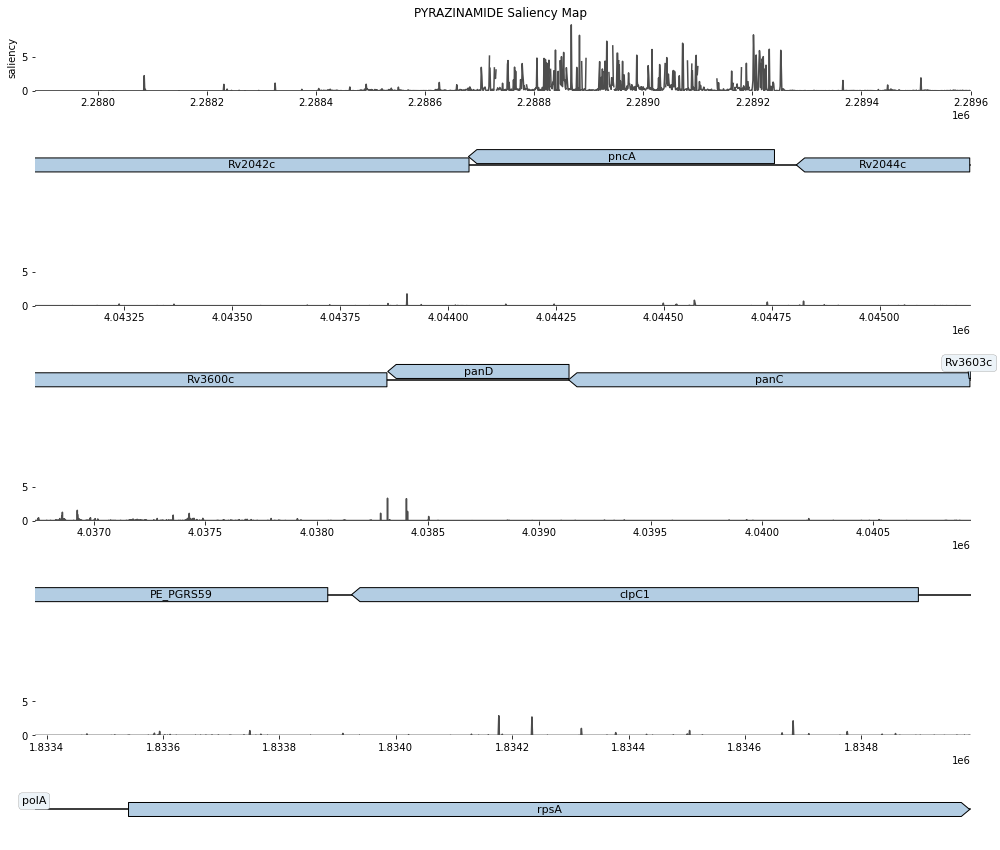

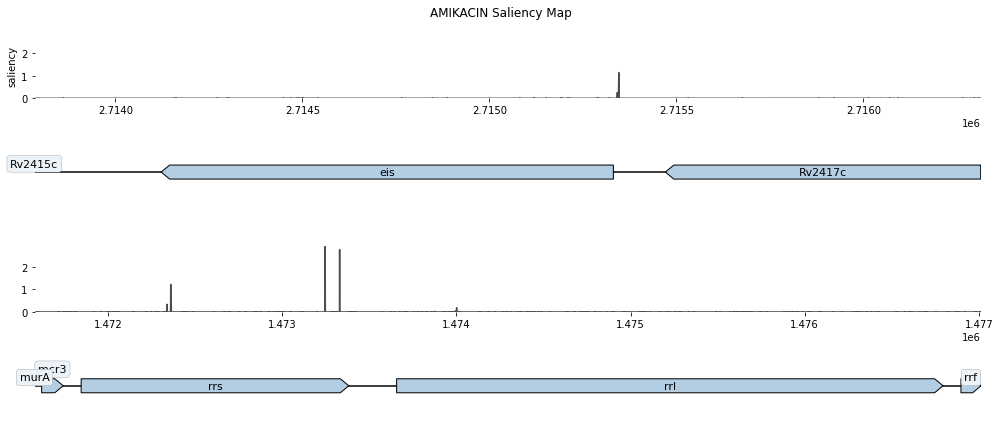

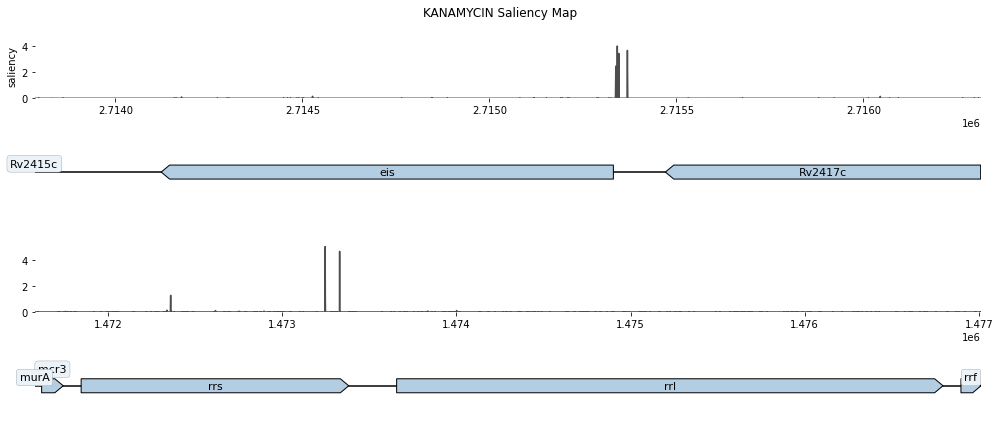

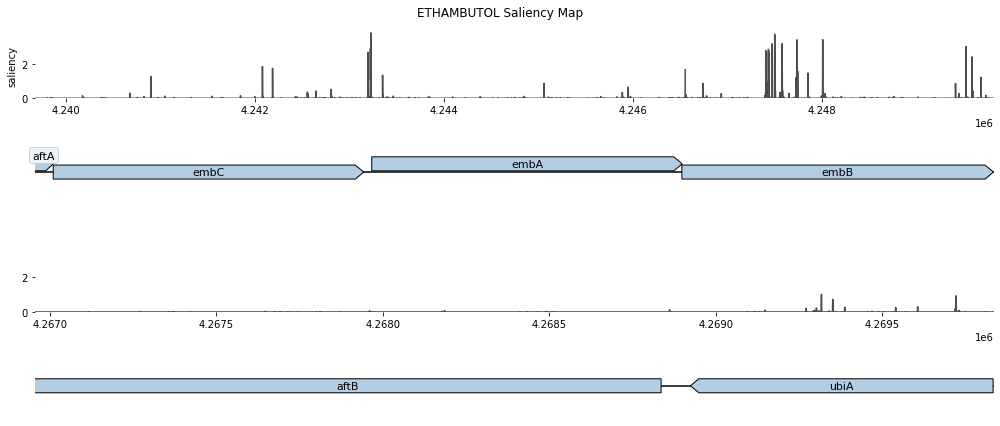

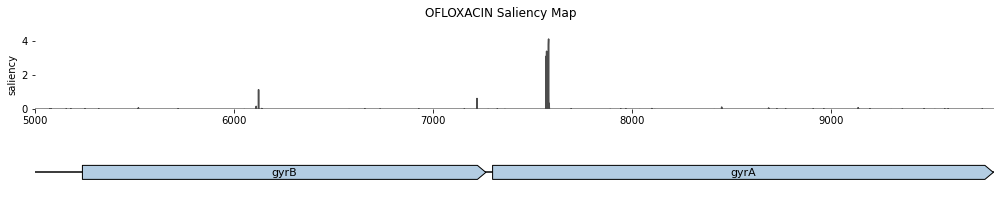

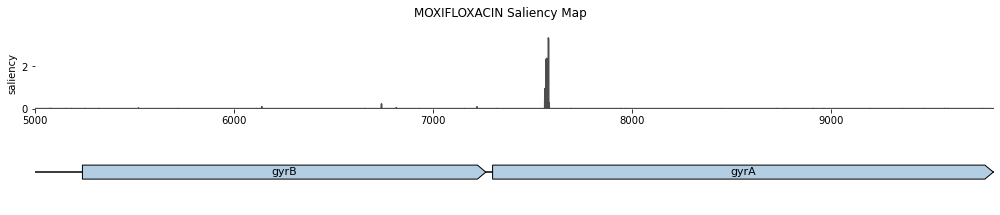

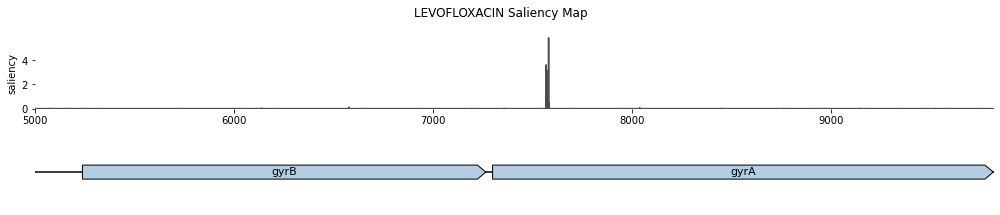

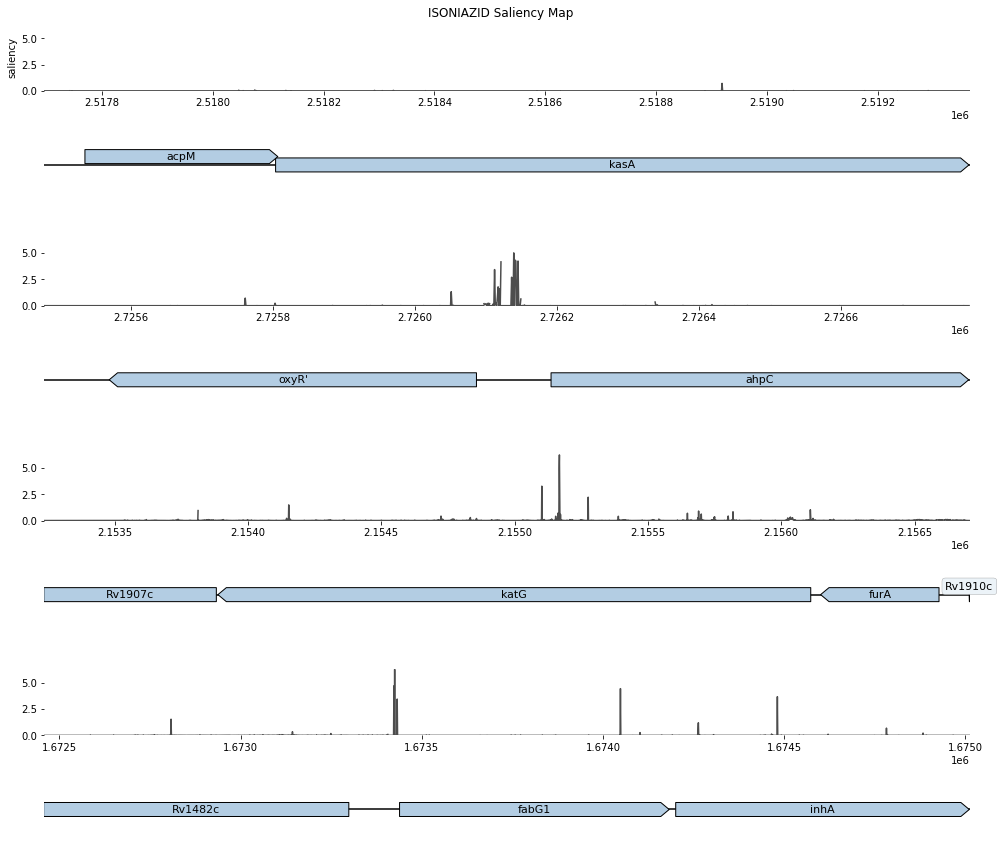

In [21]:
## Plotting max activation for each gene locus - max saliency across all resistant strains

for drug in drug_list:
    combined = np.load(f"{data_path}/sd_cnn_saliency/{drug}_max.npy")
    combined = np.abs(combined)
    allbound=np.max(combined)
    
    ## Get the relevant coordinate subset
    locus_indices = [name_list.index(x) for x in drug_to_loci[drug]]
    coords_subset = coords[0:combined.shape[0]][:,locus_indices]
    
    fig, ax = plt.subplots(coords_subset.shape[1]*2, 1, figsize=(14,3*combined.shape[1]))
    axes=ax.flatten()

    for i,name in enumerate(drug_to_loci[drug]):

        ax_coords = axes[(i)*2+1]
        ax_saliency = axes[(i)*2]
        length =int(coords_subset[0,i])+ name_to_len[name]

        cropped_record = graphic_record.crop((int(coords_subset[0,i]), int(coords_subset[0,i])+name_to_len[name]))

        cropped_record.plot(
            ax=ax_coords, with_ruler=False,
        )

        ax_coords.set_xlim([int(coords_subset[0,i]), int(coords_subset[0,i])+ name_to_len[name]])
        ax_coords.set_ylim([-4,4])

        ax_saliency.plot(coords_subset[:,i], combined[:,i], color="#4d4d4d") 
        ax_saliency.set_ylim([0, allbound+0.01*allbound])
        ax_saliency.set_xlim([int(coords_subset[0,i]), int(coords_subset[0,i])+name_to_len[name]])

        sns.despine(ax=ax_saliency, top=True, right=True, left=True, bottom=True)


    ax[0].set_ylabel("saliency")

    plt.suptitle(f"{drug.upper()} Saliency Map")
    plt.tight_layout()
    plt.savefig(f"figures/{drug}_max.pdf") 
